# Inventory Data Cleaning & Standardization Project

### Objective:
The aim of this project is to clean, standardize, and analyze product-level inventory data for better reporting and business insight.

---

### Common Issues Identified:
- Multiple naming variations for the **same product** (e.g., *CocaCola - 500ml*, *Coke 0.5L*, *Coca-Cola 500ml*)
- Inconsistent or missing **SKU codes**
- **Price variations** for identical products (e.g., same SKU or name priced differently at different hubs)
- Duplicate or non-standard **hub/location** names
- Need for **clear visual insights** across hubs

---

### What We’ll Do:
1. Load and explore the raw inventory data.
2. Standardize product names (to "Coca-Cola 500ml").
3. Standardize SKUs for similar products.
4. Set a consistent price (e.g., €2.5 for Coca-Cola 500ml).
5. Aggregate total stock per hub.
6. Visualize stock distribution by location.
7. Highlight top and bottom performing hubs.
8. Export a cleaned dataset for dashboarding or reporting.

Let’s begin!

In [ ]:

!pip install pandas pandasql

  Preparing metadata (setup.py) ... done
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26773 sha256=3cbabf21592240239d8ff1421af5dd2ee8f83552069cc8d7c011bc4c5994c242
  Stored in directory: /root/.cache/pip/wheels/68/5d/a5/edc271b998f909801d7956959f699b976cc9896075dc47c153
Successfully built pandasql


In [ ]:
# Importing libraries
import pandas as pd
import pandasql as ps

In [5]:
# Loading CSV File
df = pd.read_csv("product.csv")
df.head()

,sku,product_name,location,stock,price
0,COKE500MLUK,Coca Cola 0.5L,Paris Hub,30,1.66
1,COKE500MLUK,CocaCola - 500ml,Tokyo Hub,232,1.54
2,CC500PAR,Coca-Cola 500ml,New York Hub,213,1.09
3,COCA500,Coke 0.5L,Johannesburg Hub,475,3.10
4,CC_JHB500,Coke 0.5L,Doha Hub,36,3.54


### Step 1: Standardize Product Names
Many SKUs have slightly different product names like "Coke 0.5L", "Coca Cola 500ml", or "CocaCola - 500 ML".

To clean this, we use a SQL `CASE` statement to create a `standard_name` field where all variations are renamed to **'Coca-Cola 500ml'**.

In [7]:
query = """
SELECT
  CASE
    WHEN LOWER(product_name) LIKE '%coke%' OR LOWER(product_name) LIKE '%cola%'
    THEN 'Coca-Cola 500ml'
    ELSE product_name
  END AS standard_name,
  sku,
  price,
  stock,
  location
FROM df
"""

cleaned_df = ps.sqldf(query)
cleaned_df.head()

,standard_name,sku,price,stock,location
0,Coca-Cola 500ml,COKE500MLUK,1.66,30,Paris Hub
1,Coca-Cola 500ml,COKE500MLUK,1.54,232,Tokyo Hub
2,Coca-Cola 500ml,CC500PAR,1.09,213,New York Hub
3,Coca-Cola 500ml,COCA500,3.10,475,Johannesburg Hub
4,Coca-Cola 500ml,CC_JHB500,3.54,36,Doha Hub


### Step 2: Standardize SKUs
Even if the product names are standardized, there can still be different SKUs for the same item.

Here, we assign a single `standard_sku` for Coca-Cola 500ml using the same logic.

In [8]:
query = """
SELECT
  CASE
    WHEN LOWER(product_name) LIKE '%coke%' OR LOWER(product_name) LIKE '%cola%'
    THEN 'Coca-Cola 500ml'
    ELSE product_name
  END AS standard_name,
  CASE
    WHEN LOWER(product_name) LIKE '%coke%' OR LOWER(product_name) LIKE '%cola%'
    THEN 'COKE500'
    ELSE sku
  END AS standard_sku,
  price,
  stock,
  location
FROM df
"""

sku_cleaned_df = ps.sqldf(query)
sku_cleaned_df.head()

,standard_name,standard_sku,price,stock,location
0,Coca-Cola 500ml,COKE500,1.66,30,Paris Hub
1,Coca-Cola 500ml,COKE500,1.54,232,Tokyo Hub
2,Coca-Cola 500ml,COKE500,1.09,213,New York Hub
3,Coca-Cola 500ml,COKE500,3.10,475,Johannesburg Hub
4,Coca-Cola 500ml,COKE500,3.54,36,Doha Hub


### Step 3: Detect Price Inconsistencies
After standardizing SKUs and names, we want to find if there are **multiple prices for the same product**.

This can happen if pricing was entered differently at each location.
We use `GROUP BY` and `HAVING` to find products with more than one price.

In [9]:
query = """
SELECT
  standard_name,
  standard_sku,
  COUNT(DISTINCT price) AS price_variations
FROM sku_cleaned_df
GROUP BY standard_name, standard_sku
HAVING COUNT(DISTINCT price) > 1
"""

price_issues = ps.sqldf(query)
price_issues

,standard_name,standard_sku,price_variations
0,Coca-Cola 500ml,COKE500,292


### Step 4: Standardize Price to €2.5

After standardizing product names and SKUs, we now clean the pricing data.

Due to inconsistent pricing across different locations, we set a flat price of **€2.5** for all entries of "Coca-Cola 500ml". This simplifies reporting and ensures price consistency across the inventory system.

In [11]:
query = """
SELECT
  standard_name,
  standard_sku,
  location,
  stock,
  CASE
    WHEN standard_name = 'Coca-Cola 500ml' THEN 2.5
    ELSE price
  END AS standard_price_eur
FROM sku_cleaned_df
"""

final_cleaned_df = ps.sqldf(query)
final_cleaned_df.head()

,standard_name,standard_sku,location,stock,standard_price_eur
0,Coca-Cola 500ml,COKE500,Paris Hub,30,2.5
1,Coca-Cola 500ml,COKE500,Tokyo Hub,232,2.5
2,Coca-Cola 500ml,COKE500,New York Hub,213,2.5
3,Coca-Cola 500ml,COKE500,Johannesburg Hub,475,2.5
4,Coca-Cola 500ml,COKE500,Doha Hub,36,2.5


### Step 5: Aggregate Stock by Location

We now want to analyze the stock levels across different locations.

This helps in:
- Understanding how much stock is available per hub.
- Spotting overstocked or understocked locations.

We group the data by location and calculate the total stock of Coca-Cola 500ml at each hub.

In [12]:
query = """
SELECT
  location,
  SUM(stock) AS total_stock
FROM final_cleaned_df
WHERE standard_name = 'Coca-Cola 500ml'
GROUP BY location
ORDER BY total_stock DESC
"""

stock_by_location_df = ps.sqldf(query)
stock_by_location_df

,location,total_stock
0,New York Hub,49387
1,Doha Hub,48320
2,Dubai Hub,44732
3,Singapore Hub,42889
4,Paris Hub,41553
5,Tokyo Hub,39466
6,Madrid Hub,39454
7,London Hub,37682
8,Delhi Hub,35523
9,Johannesburg Hub,33171


### Step 5.1: Visualize Stock by Hub

Now that we have the total Coca-Cola 500ml stock by location, let's plot it in a bar chart to clearly see how stock is distributed across hubs.

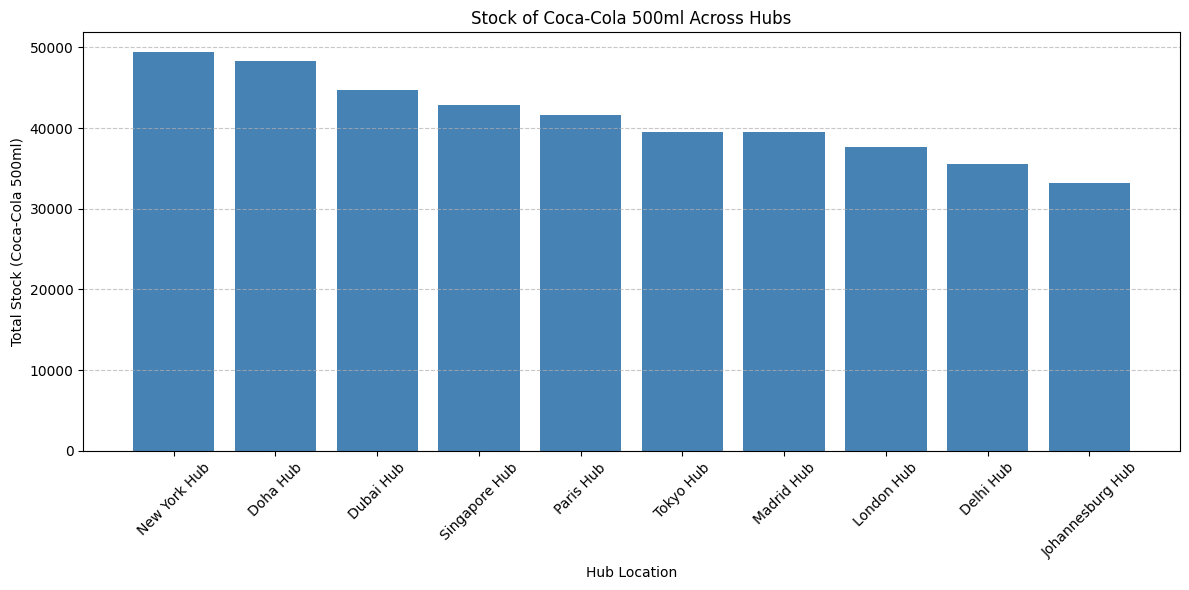

In [13]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(stock_by_location_df['location'], stock_by_location_df['total_stock'], color='steelblue')
plt.xlabel("Hub Location")
plt.ylabel("Total Stock (Coca-Cola 500ml)")
plt.title("Stock of Coca-Cola 500ml Across Hubs")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Step 6: Highlight Top & Bottom Performing Hubs

After visualizing stock levels across all hubs, we’ll now identify:

- The hub with the **highest stock**
- The hub with the **lowest stock**

This helps in quickly spotting inventory imbalances across locations.

**Why This Step Matters**

While this dataset is small and it's easy to visually spot top and bottom performing hubs, in **real-world datasets** that contain thousands of rows, it's not always obvious.

Adding this step helps to:

- Quickly identify **stock imbalances**
- Take **action faster** without scanning the full data
- Make your dashboards more insightful

This approach is especially useful when working with **live inventory dashboards** or when needing to track performance at scale.

In [14]:
# Sort by total stock
sorted_stock = stock_by_location_df.sort_values(by='total_stock', ascending=False)

# Top and Bottom performing hubs
top_hub = sorted_stock.iloc[0]
bottom_hub = sorted_stock.iloc[-1]

st_top = f"Top Hub: {top_hub['location']} with {top_hub['total_stock']} units"
st_bottom = f"Bottom Hub: {bottom_hub['location']} with {bottom_hub['total_stock']} units"

print(st_top)
print(st_bottom)

Top Hub: New York Hub with 49387 units
Bottom Hub: Johannesburg Hub with 33171 units


### Step 7: Export Cleaned Data

We’ll now export the cleaned product inventory data (with standardized product names, SKUs, price, and locations) for reporting or dashboarding purposes.

In [15]:
# Save cleaned dataframe to CSV
cleaned_df.to_csv("cleaned_inventory.csv", index=False)
print("✅ Cleaned data exported as cleaned_inventory.csv")

✅ Cleaned data exported as cleaned_inventory.csv
